In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Device: cuda
Total images: 7349


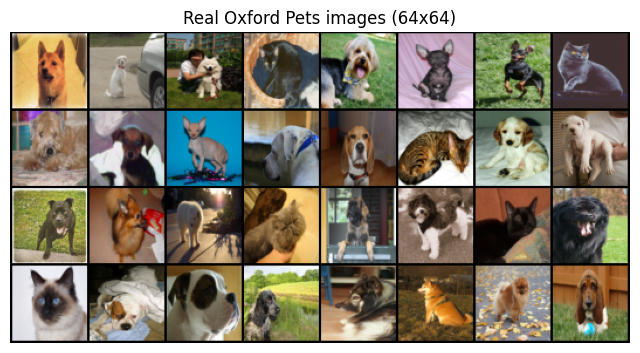

Loading checkpoint: /content/drive/MyDrive/Oxford_pets_diffusion_big/checkpoints/ddpm_big_oxford_pets_64.pth
Resuming from epoch: 200
Beginning training...
Training complete.


In [ ]:
# ============================================
# Oxford Pets 64x64 Diffusion Model (DDPM)
# Upgraded UNet: ResBlocks + Self-Attention
# - Resume training from checkpoint
# - Visualize real & generated images
# - Save loss curves
# ============================================

import os
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.utils as vutils

# -------------------------
# CONFIG & PATHS
# -------------------------
# Root dataset directory (new clean extraction)
ROOT = "/content/drive/MyDrive/Oxford_pets_new"

# Image and annotation paths
IMAGES_DIR = os.path.join(ROOT, "images", "images")
ANNOT_DIR = os.path.join(ROOT, "annotations", "annotations")
LIST_FILE = os.path.join(ANNOT_DIR, "list.txt")

# Directories for saving model outputs, checkpoints, plots
SAVE_DIR = "/content/drive/MyDrive/Oxford_pets_diffusion_big"
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(os.path.join(SAVE_DIR, "images"), exist_ok=True)        # generated samples
os.makedirs(os.path.join(SAVE_DIR, "checkpoints"), exist_ok=True)   # model checkpoints
os.makedirs(os.path.join(SAVE_DIR, "plots"), exist_ok=True)         # loss curves

# Image size & training configuration
IMAGE_SIZE = 64
BATCH_SIZE = 32
NUM_EPOCHS = 200
VIS_EVERY = 10                         # show samples every 10 epochs
CHECKPOINT_PATH = os.path.join(SAVE_DIR, "checkpoints", "ddpm_big_oxford_pets_64.pth")

# Diffusion steps (T)
T = 300
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# -------------------------
# Dataset
# -------------------------
class OxfordPetsDataset(Dataset):
    """
    Custom dataset loader for Oxford Pets.
    - Loads image paths from list.txt
    - Uses unconditional training (we ignore labels)
    """
    def __init__(self, images_dir, list_txt, transform=None):
        self.images_dir = images_dir
        self.transform = transform

        if not os.path.exists(list_txt):
            raise FileNotFoundError(f"list.txt not found: {list_txt}")

        self.items = []
        with open(list_txt, "r") as f:
            for line in f:
                if line.startswith("#"):
                    continue
                parts = line.strip().split()

                # first column = image name prefix
                if len(parts) >= 2:
                    name = parts[0]
                    img_path = os.path.join(images_dir, name + ".jpg")
                    if os.path.exists(img_path):
                        self.items.append(img_path)

        if len(self.items) == 0:
            raise RuntimeError("No images found. Check paths!")

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        img = Image.open(self.items[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

# Image preprocessing steps
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])     # map to [-1,1]
])

dataset = OxfordPetsDataset(IMAGES_DIR, LIST_FILE, transform)
print("Total images:", len(dataset))

# DataLoader for batching
loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=True
)

# -------------------------
# Visualize real training images
# -------------------------
def show_real_batch():
    """
    Displays a grid of real images (64x64) from the dataset.
    Helps check preprocessing correctness.
    """
    imgs = next(iter(loader))[:64]
    imgs_vis = (imgs * 0.5) + 0.5         # convert from [-1,1] to [0,1]
    grid = vutils.make_grid(imgs_vis, nrow=8)
    plt.figure(figsize=(8,8))
    plt.title("Real Oxford Pets images (64x64)")
    plt.imshow(grid.permute(1,2,0).cpu().numpy())
    plt.axis("off")
    plt.show()

show_real_batch()

# -------------------------
# Diffusion Utilities (DDPM forward process)
# -------------------------
def linear_beta_schedule(timesteps, start=1e-4, end=0.02):
    """Linear noise schedule used in DDPM."""
    return torch.linspace(start, end, timesteps)

# Precompute DDPM constants
betas = linear_beta_schedule(T).to(DEVICE)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = torch.cat([torch.ones(1, device=DEVICE), alphas_cumprod[:-1]], dim=0)

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

def q_sample(x_start, t, noise=None):
    """
    Forward diffusion (adding noise).
    q(x_t | x_0).
    """
    if noise is None:
        noise = torch.randn_like(x_start)

    return (
        sqrt_alphas_cumprod[t].view(-1,1,1,1) * x_start +
        sqrt_one_minus_alphas_cumprod[t].view(-1,1,1,1) * noise
    )

# -------------------------
# UNet Model (ResBlocks + Self-Attention)
# -------------------------
def sinusoidal_time_embedding(timesteps, dim=256):
    """
    Create sinusoidal embeddings to represent timestep t.
    These are injected into all ResBlocks.
    """
    device = timesteps.device
    half = dim // 2
    freq = torch.exp(torch.arange(half, device=device) * -(math.log(10000) / (half - 1)))
    angles = timesteps.float().unsqueeze(1) * freq.unsqueeze(0)
    return torch.cat([torch.sin(angles), torch.cos(angles)], dim=1)

class TimeMLP(nn.Module):
    """Projects the timestep embeddings for use inside the UNet."""
    def __init__(self, emb_dim, out_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, out_dim),
            nn.SiLU(),
            nn.Linear(out_dim, out_dim),
        )
    def forward(self, t): return self.mlp(t)

class ResBlock(nn.Module):
    """
    Core building block of UNet.
    - GroupNorm
    - Residual connection
    - Timestep conditioning
    """
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()

        # GroupNorm must divide channels → automatically choose valid group number
        g1 = 8 if in_ch % 8 == 0 else 1
        g2 = 8 if out_ch % 8 == 0 else 1

        self.norm1 = nn.GroupNorm(g1, in_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.norm2 = nn.GroupNorm(g2, out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)

        # Map time embedding to channel dimension
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)

        self.shortcut = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = self.norm1(x)
        h = F.silu(h)
        h = self.conv1(h)

        # Inject time information
        h += self.time_mlp(t_emb).unsqueeze(-1).unsqueeze(-1)

        h = self.norm2(h)
        h = F.silu(h)
        h = self.conv2(h)
        return h + self.shortcut(x)

class SelfAttention2d(nn.Module):
    """
    Simple attention block used at:
    - 32×32
    - 16×16
    - 8×8
    """
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)
        self.q = nn.Conv2d(channels, channels, 1)
        self.k = nn.Conv2d(channels, channels, 1)
        self.v = nn.Conv2d(channels, channels, 1)
        self.proj = nn.Conv2d(channels, channels, 1)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x)

        q = self.q(h).reshape(B, C, H*W).permute(0,2,1)
        k = self.k(h).reshape(B, C, H*W)
        v = self.v(h).reshape(B, C, H*W).permute(0,2,1)

        attn = torch.bmm(q, k) / math.sqrt(C)
        attn = F.softmax(attn, dim=-1)

        out = torch.bmm(attn, v)
        out = out.permute(0,2,1).reshape(B, C, H, W)

        return x + self.proj(out)

class UNetBig(nn.Module):
    """
    Full UNet for DDPM:
    - 4 encoder stages
    - 4 decoder stages
    - Bottleneck with attention
    - Skip connections
    """
    def __init__(self, time_dim=256):
        super().__init__()
        self.time_dim = time_dim
        self.time_mlp = TimeMLP(time_dim, time_dim)

        # ---------------- Encoder (Downsampling Path) ----------------
        self.enc1_1 = ResBlock(3, 128, time_dim)  #Stage 1 — Input Resolution: 64×64
        self.enc1_2 = ResBlock(128, 128, time_dim)
        self.down1 = nn.Conv2d(128, 128, 4, 2, 1)   # → output 32×32

        self.enc2_1 = ResBlock(128, 256, time_dim)  #Stage 2 — 32×32 + Self-Attention
        self.enc2_2 = ResBlock(256, 256, time_dim)
        self.attn2 = SelfAttention2d(256)
        self.down2 = nn.Conv2d(256, 256, 4, 2, 1)   # → output 16×16

        self.enc3_1 = ResBlock(256, 512, time_dim)  #Stage 3 — 16×16 + Self-Attention
        self.enc3_2 = ResBlock(512, 512, time_dim)
        self.attn3 = SelfAttention2d(512)
        self.down3 = nn.Conv2d(512, 512, 4, 2, 1)   # → output 8×8

        self.enc4_1 = ResBlock(512, 512, time_dim)  #Stage 4 — 8×8 + Self-Attention
        self.enc4_2 = ResBlock(512, 512, time_dim)
        self.attn4 = SelfAttention2d(512)
        self.down4 = nn.Conv2d(512, 512, 4, 2, 1)   # → output 4×4

        # ---------------- Bottleneck ----------------
        self.bot1 = ResBlock(512, 512, time_dim)
        self.bot_attn = SelfAttention2d(512)
        self.bot2 = ResBlock(512, 512, time_dim)

        # ---------------- Decoder (Upsampling Path) ----------------

        '''
        Each decoder stage:

            Uses ConvTranspose2d to upsample

            Concatenates skip-connections

            Applies ResBlocks

            Includes attention at relevant resolutions
        '''



        self.up4 = nn.ConvTranspose2d(512, 512, 4, 2, 1) #Stage 4 Decoder — 4→8 resolution
        self.dec4_1 = ResBlock(1024, 512, time_dim)
        self.dec4_2 = ResBlock(512, 512, time_dim)
        self.dec4_attn = SelfAttention2d(512)

        self.up3 = nn.ConvTranspose2d(512, 512, 4, 2, 1) #Stage 3 Decoder — 8→16 resolution
        self.dec3_1 = ResBlock(1024, 512, time_dim)
        self.dec3_2 = ResBlock(512, 256, time_dim)
        self.dec3_attn = SelfAttention2d(256)

        self.up2 = nn.ConvTranspose2d(256, 256, 4, 2, 1) #Stage 2 Decoder — 16→32 resolution
        self.dec2_1 = ResBlock(512, 256, time_dim)
        self.dec2_2 = ResBlock(256, 128, time_dim)

        self.up1 = nn.ConvTranspose2d(128, 128, 4, 2, 1) #Stage 1 Decoder — 32→64 resolution
        self.dec1_1 = ResBlock(256, 128, time_dim)
        self.dec1_2 = ResBlock(128, 64, time_dim)

        self.final = nn.Conv2d(64, 3, 1)  # output predicted noise ε. Produces RGB image noise prediction εθ(xₜ).

def forward(self, x, t):

        # Compute timestep embeddings
        # ---------------------------
        # Convert integer timestep t → sinusoidal embedding → MLP.
        # This produces a time-dependent vector added into every ResBlock.
        t_emb = self.time_mlp(sinusoidal_time_embedding(t, self.time_dim))

        # ---- Encoder ----
        # Level 1 (64×64 → 64×64 features)
        # Two ResBlocks extract low-level features at the highest resolution.
        e1 = self.enc1_1(x, t_emb)
        e1 = self.enc1_2(e1, t_emb)
        # Downsample to 32×32
        d1 = self.down1(e1)

        # Level 2 (32×32)
        # Two ResBlocks extract mid-level features.
        e2 = self.enc2_1(d1, t_emb)
        e2 = self.enc2_2(e2, t_emb)
        # Add self-attention to allow global context mixing.
        e2 = self.attn2(e2)
        # Downsample to 16×16
        d2 = self.down2(e2)

        # Level 3 (16×16)
        # Two ResBlocks + attention for deeper feature extraction.
        e3 = self.enc3_1(d2, t_emb)
        e3 = self.enc3_2(e3, t_emb)
        e3 = self.attn3(e3)
        # Downsample to 8×8
        d3 = self.down3(e3)

        # Level 4 (8×8)
        # Two more ResBlocks + attention at the deepest encoder stage.
        e4 = self.enc4_1(d3, t_emb)
        e4 = self.enc4_2(e4, t_emb)
        e4 = self.attn4(e4)
        # Downsample to 4×4 (bottleneck)
        d4 = self.down4(e4)

        # ---- Bottleneck ----
        # The most compressed representation.
        # Two ResBlocks + attention allow global reasoning.
        b = self.bot1(d4, t_emb)
        b = self.bot_attn(b)
        b = self.bot2(b, t_emb)

        # ---- Decoder ----
        # Each decoder stage upsamples and merges skipped encoder features.

        # Decoder level 4 (4×4 → 8×8)
        u4 = self.up4(b)
        # Concatenate skip connection from encoder level 4
        u4 = self.dec4_1(torch.cat([u4, e4], dim=1), t_emb)
        u4 = self.dec4_2(u4, t_emb)
        # Attention at 8×8 resolution
        u4 = self.dec4_attn(u4)

        # Decoder level 3 (8×8 → 16×16)
        u3 = self.up3(u4)
        u3 = self.dec3_1(torch.cat([u3, e3], dim=1), t_emb)
        u3 = self.dec3_2(u3, t_emb)
        u3 = self.dec3_attn(u3)

        # Decoder level 2 (16×16 → 32×32)
        u2 = self.up2(u3)
        u2 = self.dec2_1(torch.cat([u2, e2], dim=1), t_emb)
        u2 = self.dec2_2(u2, t_emb)

        # Decoder level 1 (32×32 → 64×64)
        u1 = self.up1(u2)
        u1 = self.dec1_1(torch.cat([u1, e1], dim=1), t_emb)
        u1 = self.dec1_2(u1, t_emb)

        # Final 1×1 conv generates predicted noise ε
        return self.final(u1)



# Instantiate model and optimizer
model = UNetBig().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
mse_loss = nn.MSELoss()

# -------------------------
# DDPM Reverse Sampling
# -------------------------
@torch.no_grad()
def p_sample(model, x, t):
    """
    Perform ONE DDPM reverse step:
    x_t → x_{t-1}
    This applies the DDPM formula using the model prediction ε_θ.
    """

    # Select βₜ, sqrt(1 - ᾱₜ), 1/sqrt(αₜ) for this timestep
    betas_t = betas[t].view(-1,1,1,1)
    sqrt_one_minus_ac = sqrt_one_minus_alphas_cumprod[t].view(-1,1,1,1)
    sqrt_recip_a = sqrt_recip_alphas[t].view(-1,1,1,1)

    # Model predicts noise ε_θ(x_t, t)
    eps_theta = model(x, t)

    # Compute mean of p(x_{t-1} | x_t) according to DDPM equation
    model_mean = sqrt_recip_a * (x - betas_t / sqrt_one_minus_ac * eps_theta)

    # If t == 0 → return mean (final output), no noise added
    if (t == 0).all():
        return model_mean

    # Otherwise sample noise for stochasticity
    noise = torch.randn_like(x)
    var = posterior_variance[t].view(-1,1,1,1)
    return model_mean + torch.sqrt(var) * noise


@torch.no_grad()
def p_sample_loop(model, shape):
    """
    Generate a full image by iteratively sampling:
        x_T → x_{T-1} → ... → x_1 → x_0
    Starting from pure Gaussian noise.
    """
    img = torch.randn(shape, device=DEVICE)

    # Loop backwards from T → 0
    for t in reversed(range(T)):
        img = p_sample(
            model,
            img,
            torch.full((shape[0],), t, device=DEVICE, dtype=torch.long)
        )

    return img


# -------------------------
# Training loop (Checkpoint + Visualization)
# -------------------------
start_epoch = 0
loss_history = []

# Resume if checkpoint exists
if os.path.exists(CHECKPOINT_PATH):
    print("Loading checkpoint:", CHECKPOINT_PATH)
    ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
    model.load_state_dict(ckpt["model"])
    optimizer.load_state_dict(ckpt["optimizer"])
    loss_history = ckpt.get("loss_history", [])
    start_epoch = ckpt.get("epoch", 0) + 1
    print("Resuming from epoch:", start_epoch)
else:
    print("No checkpoint found. Starting new training.")

print("Beginning training...")
for epoch in range(start_epoch, NUM_EPOCHS):

    model.train()
    running_loss = 0.0

    # Loop over batches
    for x0 in loader:
        x0 = x0.to(DEVICE)

        # Sample random timestep t for each image
        t = torch.randint(0, T, (x0.size(0),), device=DEVICE).long()

        noise = torch.randn_like(x0)
        x_t = q_sample(x0, t, noise)  # forward diffusion

        noise_pred = model(x_t, t)    # model predicts noise
        loss = mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {avg_loss:.4f}")

    # Save checkpoint every epoch
    torch.save({
        "epoch": epoch,
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "loss_history": loss_history
    }, CHECKPOINT_PATH)

    # Visualize results every VIS_EVERY epochs
    if (epoch + 1) % VIS_EVERY == 0:
        model.eval()
        with torch.no_grad():
            # Generate 16 samples for visualization
            samples = p_sample_loop(model, (16, 3, IMAGE_SIZE, IMAGE_SIZE))
            samples = samples.clamp(-1, 1)
            samples_vis = (samples + 1) / 2.0   # map to [0,1]

            # Prepare grid
            grid = vutils.make_grid(samples_vis, nrow=4)
            npimg = grid.permute(1,2,0).cpu().numpy()

        # Show samples in notebook
        plt.figure(figsize=(6,6))
        plt.title(f"Generated samples at epoch {epoch+1}")
        plt.imshow(npimg)
        plt.axis("off")
        plt.show()

        # Save generated samples
        img_path = os.path.join(SAVE_DIR, "images", f"samples_epoch_{epoch+1:04d}.png")
        vutils.save_image(samples_vis, img_path, nrow=4)
        print("Saved generated samples to:", img_path)

        # Plot training loss curve
        plt.figure(figsize=(8,5))
        plt.plot(loss_history, label="Training loss (MSE)")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Diffusion Training Loss")
        plt.legend()

        loss_plot_path = os.path.join(SAVE_DIR, "plots", f"loss_epoch_{epoch+1:04d}.png")
        plt.savefig(loss_plot_path)
        plt.show()

        print("Saved loss plot to:", loss_plot_path)

print("Training complete.")


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Correct directories based on your training code
BASE_DIR = "/content/drive/MyDrive/Oxford_pets_diffusion_big"
IMG_DIR = os.path.join(BASE_DIR, "images")
LOSS_DIR = os.path.join(BASE_DIR, "plots")

def load_results(start=100, end=200, step=10):
    """
    Load and display generated images + loss curves
    for epochs in a given range.
    """

    for epoch in range(start, end + 1, step):
        img_path = os.path.join(IMG_DIR, f"samples_epoch_{epoch:04d}.png")
        loss_path = os.path.join(LOSS_DIR, f"loss_epoch_{epoch:04d}.png")

        print(f"\n===== RESULTS FOR EPOCH {epoch} =====")

        # --- Display generated samples ---
        if os.path.exists(img_path):
            img = Image.open(img_path)
            plt.figure(figsize=(6,6))
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Generated Samples at Epoch {epoch}")
            plt.show()
        else:
            print(f"❌ Missing generated samples for epoch {epoch}: {img_path}")

        # --- Display loss curve ---
        if os.path.exists(loss_path):
            loss_img = Image.open(loss_path)
            plt.figure(figsize=(7,5))
            plt.imshow(loss_img)
            plt.axis('off')
            plt.title(f"Loss Curve at Epoch {epoch}")
            plt.show()
        else:
            print(f"❌ Missing loss curve for epoch {epoch}: {loss_path}")

# Load results 100 → 200
load_results(start=100, end=200, step=10)


Output hidden; open in https://colab.research.google.com to view.

Loaded model from epoch: 200


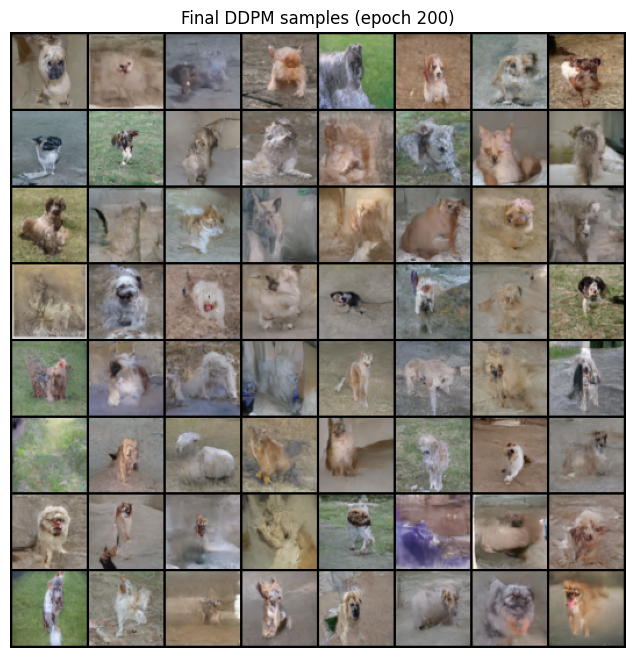

Saved final sample grid to: /content/drive/MyDrive/Oxford_pets_diffusion_big/final_samples_epoch200.png


In [ ]:
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import os

# Use the same values you used during training
IMAGE_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path to your final checkpoint
CHECKPOINT_PATH = "/content/drive/MyDrive/Oxford_pets_diffusion_big/checkpoints/ddpm_big_oxford_pets_64.pth"

# Load checkpoint
ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model"])
model.to(DEVICE)
model.eval()

print("Loaded model from epoch:", ckpt["epoch"] + 1)

# Generate a bigger batch of samples for final results
with torch.no_grad():
    samples = p_sample_loop(model, (64, 3, IMAGE_SIZE, IMAGE_SIZE))
    samples = samples.clamp(-1, 1)
    samples_vis = (samples + 1) / 2.0  # [-1,1] -> [0,1]

# Make grid for visualization
grid = vutils.make_grid(samples_vis, nrow=8)
npimg = grid.permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(8,8))
plt.title("Final DDPM samples (epoch 200)")
plt.imshow(npimg)
plt.axis("off")
plt.show()

# Save to Drive
final_img_path = "/content/drive/MyDrive/Oxford_pets_diffusion_big/final_samples_epoch200.png"
vutils.save_image(samples_vis, final_img_path, nrow=8)
print("Saved final sample grid to:", final_img_path)


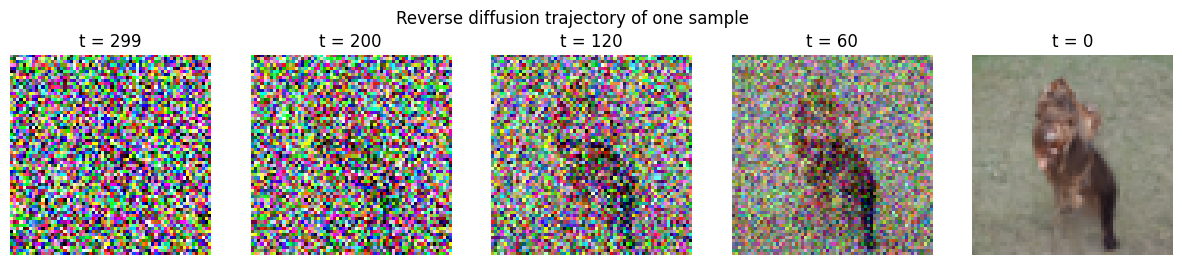

In [ ]:
import math

@torch.no_grad()
def denoising_trajectory(model, steps_to_show=[299, 200, 120, 60, 0]):
    """
    Show intermediate x_t during reverse diffusion for a SINGLE sample.
    steps_to_show: list of timesteps t (0..T-1) you want to visualize.
    """
    model.eval()
    b = 1
    x = torch.randn((b, 3, IMAGE_SIZE, IMAGE_SIZE), device=DEVICE)

    # We already have betas, posterior_variance, etc. defined from training.
    imgs = {}
    for t in reversed(range(T)):
        t_batch = torch.full((b,), t, device=DEVICE, dtype=torch.long)
        x = p_sample(model, x, t_batch)
        if t in steps_to_show:
            imgs[t] = (x.clamp(-1,1) + 1) / 2.0  # store [0,1] version

    # Plot them in order of decreasing noise
    steps_to_show_sorted = sorted(steps_to_show, reverse=True)
    n = len(steps_to_show_sorted)

    plt.figure(figsize=(3*n, 3))
    for i, t in enumerate(steps_to_show_sorted):
        img = imgs[t][0].cpu()
        plt.subplot(1, n, i+1)
        plt.imshow(img.permute(1,2,0))
        plt.title(f"t = {t}")
        plt.axis("off")
    plt.suptitle("Reverse diffusion trajectory of one sample")
    plt.show()

# Example usage
denoising_trajectory(model, steps_to_show=[299, 200, 120, 60, 0])
